In [20]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import pickle as pkl
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.datasets import make_classification
from pydeseq2.dds import DeseqDataSet
from pydeseq2.default_inference import DefaultInference
from pydeseq2.ds import DeseqStats
from pydeseq2.utils import load_example_data
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.model_selection import train_test_split

Preprocessing Steps/Exploration
====

In [8]:
counts_normal = pd.read_csv("./../../project_data/GSE131512_normalTPM.txt", sep = "\t")
counts_cancer =pd.read_csv("./../../project_data/GSE131512_cancerTPM.txt", sep = "\t")
metadata = pd.read_excel("./../../project_data/GSE131512_metaData.xlsx")

In [15]:
all_donors = pd.concat([counts_normal, counts_cancer], axis = 1)
all_donors.index.name = 'Ensembl'
# give each gene its proper label
gene_labels = pd.read_csv("../data/ensembl_to_symbol.txt", sep = "\t")
all_donors = all_donors.merge(gene_labels, left_index=True, right_on='Ensembl', how='left').set_index('Symbol').drop(columns='Ensembl')
# remove any genes with a null name
all_donors = all_donors[~all_donors.index.isnull()]
all_donors.index.name = None


PCA before filtering for predetermined genes

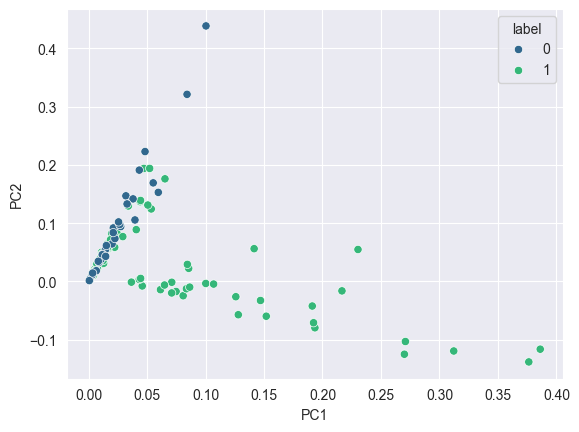

In [16]:
def label_PCA(all_donors, metadata):
    pca = PCA()
    pca.fit(all_donors.iloc[:, 1:])
    pc_f = pd.DataFrame()
    pc_f["PC1"] = pca.components_[0]
    pc_f["PC2"] = pca.components_[1]
    pc_f['label'] = metadata['Sample name'].apply(lambda x: 1 if 'C' in x else 0)
    sns.scatterplot(data=pc_f, x='PC1', y='PC2', hue='label', palette='viridis')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.show()
label_PCA(all_donors, metadata)


Filter for preselected genes
====


In [17]:
# after filtering for selected genes
with open("../data/prior_association.txt", 'r') as file:
    content = file.read()
entries = [entry.strip().replace(' ', '') for entry in content.split(',')]
all_donors_filtered = all_donors[all_donors.index.isin(entries)]
print(f"shape before filtering: {all_donors.shape}")
print(f"shape after filtering: {all_donors_filtered.shape}")
all_donors_filtered

shape before filtering: (41355, 128)
shape after filtering: (604, 128)


,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96
BAD,9.357517,0.000000,0.000000,30.886131,0.000000,40.526054,0.000000,0.000000,0.000000,0.000000,...,0.000000,5.737205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RBM5,11.561515,6.711091,3.520775,1.272027,8.455689,6.676167,0.000000,10.394128,16.035700,11.292366,...,16.486083,16.067274,11.945673,2.224521,8.156391,0.000000,22.272080,1.950614,2.146163,4.491492
SLC7A2,10.109196,34.108131,0.000000,1.668359,34.657095,4.378147,3.359905,17.040847,26.768028,8.078610,...,13.514208,18.594206,17.408496,14.588128,21.395437,41.037636,8.520021,5.116752,29.555961,16.200053
AP2B1,27.385568,6.878271,0.000000,33.027440,8.666329,10.643854,3.500731,5.326528,14.941060,7.014346,...,21.120960,19.373560,16.324337,12.159657,41.399802,4.750853,21.558739,45.315327,1.466417,4.603380
GAS7,16.615614,13.778334,7.228396,5.223120,16.275109,10.279975,14.463393,10.669933,17.209438,8.430549,...,15.865814,13.582976,9.537615,0.000000,13.157286,17.843923,11.431531,3.003559,19.827995,5.763340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GABRQ,22.011087,15.501184,0.000000,2.136808,19.530834,7.476615,0.000000,24.008213,2.448862,0.000000,...,25.963176,15.876777,17.837221,0.000000,54.805875,73.000494,26.501321,0.000000,16.223489,7.545008
FGF14-AS2,37.203535,80.982992,45.317690,0.000000,10.203514,0.000000,0.000000,25.085270,21.109463,0.000000,...,0.000000,36.495891,51.252945,0.000000,56.241996,0.000000,0.000000,28.245760,0.000000,0.000000
NEFL,23.997956,4.018283,44.972233,12.186074,43.034361,18.654405,0.000000,46.676334,10.474273,44.256001,...,9.871085,9.054421,38.146683,0.000000,33.487957,0.000000,13.335466,11.679351,0.000000,26.892924
OR12D2,0.000000,0.000000,0.000000,0.000000,29.432158,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.563994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.052804,0.000000,0.000000


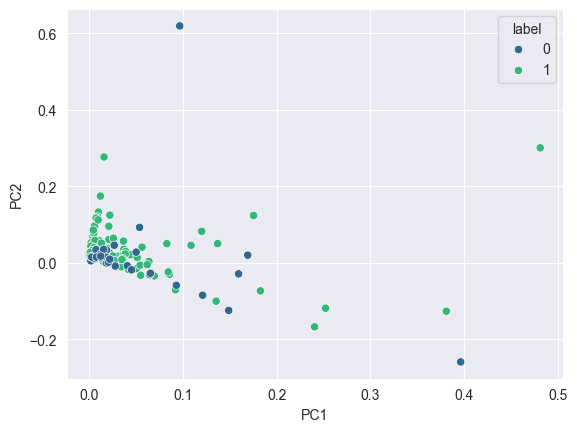

In [18]:
label_PCA(all_donors_filtered, metadata)

perform differential expresssion analysis using DESEQ2
===

In [19]:
# some extra preprocessing
all_donors_filtered = all_donors_filtered.T
all_donors_filtered.index.name = None
metadata['label'] = metadata['Sample name'].apply(lambda x: 1 if 'C' in x else 0)
cancer_metadata =  metadata.head(96)
normal_metadata = metadata.tail(32)
metadata = pd.concat([normal_metadata, cancer_metadata])
metadata.set_index('Sample name', inplace=True)
metadata.index.name = None
metadata.head(3)

,Age,Gender,label
N1,41.0,Female,0
N2,40.0,Female,0
N3,29.0,Female,0


In [21]:
def perform_DSEQ2(donors, metadata):
    inference = DefaultInference(n_cpus=8)
    dds = DeseqDataSet(
    counts=donors.astype(int),
    metadata=metadata,
    design_factors="label",
    refit_cooks=True,
    inference=inference,
)
    dds.fit_size_factors()
    dds.obsm["size_factors"]
    dds.deseq2()
    stat_res = DeseqStats(dds, inference=inference)
    stat_res.summary()
    return dds, stat_res

`For cancer vs healthy`
===

In [22]:
dds_, stat_res_= perform_DSEQ2(all_donors_filtered, metadata)

Fitting size factors...
... done in 0.01 seconds.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.25 seconds.

Fitting dispersion trend curve...
... done in 0.03 seconds.

Fitting MAP dispersions...
... done in 0.37 seconds.

Fitting LFCs...
... done in 0.20 seconds.

Replacing 15 outlier genes.

Fitting dispersions...
... done in 0.02 seconds.

Fitting MAP dispersions...
... done in 0.02 seconds.

Fitting LFCs...
... done in 0.02 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: label 1 vs 0
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
BAD         4.465090       -0.818966  0.749496 -1.092690  0.274530  0.628847
RBM5       10.937392        0.249415  0.219912  1.134161  0.256727  0.628847
SLC7A2     16.341295       -0.005598  0.196245 -0.028527  0.977242  0.990958
AP2B1      16.491672        0.273709  0.211266  1.295565  0.195126  0.572500
GAS7       11.883239       -0.288757  0.176954 -1.631826  0.102716  0.440319
...              ...             ...       ...       ...       ...       ...
GABRQ      14.337749        1.182226  0.292331  4.044133  0.000053  0.003699
FGF14-AS2  17.462827       -0.591284  0.580611 -1.018382  0.308497  0.655555
NEFL       12.262377       -0.443407  0.279180 -1.588249  0.112230  0.460064
OR12D2      2.147251        0.803456  1.408753  0.570331  0.568453       NaN
CCAT2      13.955493       -0.156769  0.456606 -0.343336  0.731345  0.902541

[604 rows x 6 columns]


... done in 0.17 seconds.



obtain the signficant genes according to padj < 0.05

In [23]:
filtered_df = stat_res_.results_df[stat_res_.results_df["padj"] < abs(0.05)]
genes_of_interest = filtered_df.index.to_numpy()
print(f" number of genes of interest {len(genes_of_interest)}")
print(genes_of_interest)
all_donors_filtered_fold = all_donors_filtered[genes_of_interest]
all_donors_filtered_fold["label"] = metadata["label"]

 number of genes of interest 22
['ACTB' 'CIRBP' 'CLCN7' 'MGP' 'DNMT3A' 'RAC2' 'KRAS' 'STXBP1' 'PLAA'
 'CYP4V2' 'SH3KBP1' 'LPCAT1' 'YWHAZ' 'MTHFR' 'PLEC' 'PKP3' 'MAFF'
 'RTN4RL1' 'TUBB' 'UCKL1' 'MALAT1' 'GABRQ']


C:\Users\albao\AppData\Local\Temp\ipykernel_21192\3214511039.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  all_donors_filtered_fold["label"] = metadata["label"]


`for non reccurent cancer vs recurrent cancer`
==

In [24]:
# need to keep in mind it is mostly heterogenous so first find general genes and then go individual level
patient_info = pd.read_csv("./../../project_data\pnas_patient_info.csv")
num_recurrent_patients = (patient_info['recurStatus'] == 'R').sum()
num_normalcancer_patients = (patient_info['recurStatus'] == 'N').sum()

print(f"Number of recurrence patients: {num_recurrent_patients}")
print(f"Number of normal cancer patients: {num_normalcancer_patients}")
 
patient_info["label"] = np.where(patient_info['recurStatus'] == 'R', 1, 0)
counts_cancer = pd.read_csv("./../../project_data/GSE131512_cancerTPM.txt", sep = "\t")
gene_labels = pd.read_csv("../data/ensembl_to_symbol.txt", sep = "\t")
cancer_donors = counts_cancer.merge(gene_labels, left_index=True, right_on='Ensembl', how='left').set_index('Symbol').drop(columns='Ensembl')

#filter for genes
with open(r"../data/prior_association.txt", 'r') as file:
    content = file.read()
entries = [entry.strip().replace(' ', '') for entry in content.split(',')]
cancer_donors_filtered = cancer_donors[cancer_donors.index.isin(entries)]



new_index = ['C' + str(i) for i in range(1, len(patient_info) + 1)]
# Set the new index
patient_info.index = new_index
cancer_donors_filtered.index.name = None
cancer_donors_filtered

Number of recurrence patients: 28
Number of normal cancer patients: 68


,C1,C2,C3,C4,C5,C6,C7,C8,C9,C10,...,C87,C88,C89,C90,C91,C92,C93,C94,C95,C96
BAD,12.517458,8.940605,24.422888,6.110395,0.000000,7.467200,0.000000,0.000000,6.595136,0.000000,...,0.000000,5.737205,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
RBM5,6.186290,11.782835,12.070108,14.092570,9.525802,13.531419,23.905604,4.029709,19.556411,16.134479,...,16.486083,16.067274,11.945673,2.224521,8.156391,0.000000,22.272080,1.950614,2.146163,4.491492
SLC7A2,14.875269,11.590553,24.625768,15.842967,21.864157,16.134064,39.605042,42.282125,12.824850,11.756433,...,13.514208,18.594206,17.408496,14.588128,21.395437,41.037636,8.520021,5.116752,29.555961,16.200053
AP2B1,29.588520,16.101810,9.163546,24.760509,16.271833,15.129273,17.193767,27.533956,56.418971,39.197407,...,21.120960,19.373560,16.324337,12.159657,41.399802,4.750853,21.558739,45.315327,1.466417,4.603380
GAS7,16.934510,10.583552,8.260256,8.266578,8.556245,8.839390,16.790479,12.409908,5.576482,18.402891,...,15.865814,13.582976,9.537615,0.000000,13.157286,17.843923,11.431531,3.003559,19.827995,5.763340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
GABRQ,5.196003,9.896665,15.770147,10.145711,12.001400,20.664254,33.817008,9.025713,29.201537,3.011491,...,25.963176,15.876777,17.837221,0.000000,54.805875,73.000494,26.501321,0.000000,16.223489,7.545008
FGF14-AS2,29.860082,0.000000,0.000000,9.717462,11.494823,11.875212,0.000000,77.802653,31.465064,0.000000,...,0.000000,36.495891,51.252945,0.000000,56.241996,0.000000,0.000000,28.245760,0.000000,0.000000
NEFL,12.346858,3.527501,19.272022,19.286772,48.480591,5.892343,9.040132,38.604781,44.235708,12.880749,...,9.871085,9.054421,38.146683,0.000000,33.487957,0.000000,13.335466,11.679351,0.000000,26.892924
OR12D2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,9.563994,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.052804,0.000000,0.000000


In [25]:
dds, stat_res = perform_DSEQ2(cancer_donors_filtered.T, patient_info)

Fitting size factors...
... done in 0.00 seconds.

Fitting size factors...
... done in 0.00 seconds.

Fitting dispersions...
... done in 0.30 seconds.

Fitting dispersion trend curve...
... done in 0.04 seconds.

Fitting MAP dispersions...
... done in 0.28 seconds.

Fitting LFCs...
... done in 0.22 seconds.

Replacing 34 outlier genes.

Fitting dispersions...
... done in 0.05 seconds.

Fitting MAP dispersions...
... done in 0.05 seconds.

Fitting LFCs...
... done in 0.06 seconds.

Running Wald tests...


Log2 fold change & Wald test p-value: label 1 vs 0
            baseMean  log2FoldChange     lfcSE      stat    pvalue      padj
BAD         3.970799        1.512045  0.797370  1.896290  0.057922  0.865761
RBM5       11.867326       -0.300037  0.233409 -1.285455  0.198633  0.966101
SLC7A2     17.558181       -0.128577  0.216863 -0.592895  0.553252  0.992328
AP2B1      18.017726       -0.015229  0.222037 -0.068586  0.945319  0.992939
GAS7       12.193719       -0.098248  0.219016 -0.448589  0.653728  0.992328
...              ...             ...       ...       ...       ...       ...
GABRQ      17.397568       -0.592430  0.289589 -2.045762  0.040780  0.865761
FGF14-AS2  16.349026        0.630854  0.627883  1.004732  0.315026  0.966101
NEFL       11.674552        0.129938  0.285431  0.455236  0.648940  0.992328
OR12D2      2.554434       -2.477522  1.428088 -1.734852  0.082767  0.865761
CCAT2      14.648550        0.239792  0.511322  0.468964  0.639095  0.992328

[604 rows x 6 columns]


... done in 0.24 seconds.



Cancer Vs Healthy classification
===

In [26]:
X = all_donors_filtered_fold.drop(columns = ["label"])
y = all_donors_filtered_fold["label"]
print("SVM")
clf = SVC(C = 3)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
print("")
print("logistic regression")
clf = LogisticRegression(C = 6)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
print("")
print("Random Forest Classifier")
clf = RandomForestClassifier(max_depth = 3, n_estimators = 100)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
print("")
print("Gradient Boosting")
clf = GradientBoostingClassifier(n_estimators = 50)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
print("")
print("AdaBoost Classifer")
clf = AdaBoostClassifier(n_estimators=50)

scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=10)
print(f"Average AUROC with 10-fold CV:{scores.mean()}")

SVM
Average AUROC with 10-fold CV: 1.0

logistic regression
Average AUROC with 10-fold CV: 1.0

Random Forest Classifier
Average AUROC with 10-fold CV: 1.0

Gradient Boosting
Average AUROC with 10-fold CV: 0.9497222222222221

AdaBoost Classifer
Average AUROC with 10-fold CV:0.986111111111111


Non Recurrence vs Recurrence (no individual analysis) Classification
======

looking at only over expressed genes > 1 log2fold
===

In [27]:
# obtain genes of interest overall
filtered_df = stat_res.results_df[stat_res.results_df["log2FoldChange"] > 1]
genes_of_interest = filtered_df.index.to_numpy()
print(f" number of genes of interest {len(genes_of_interest)}")
print(genes_of_interest)
cancer_donors_filtered_fold = cancer_donors_filtered.T[genes_of_interest]
cancer_donors_filtered_fold["label"] = patient_info["label"]

 number of genes of interest 10
['BAD' 'CYP2D6' 'APOL1' 'SLC25A25' 'GNB2' 'SNCG' 'UBE2C' 'SOCS1' 'UCKL1'
 'TMEFF1']


In [34]:
X = cancer_donors_filtered_fold.drop(columns = ["label"])
y = cancer_donors_filtered_fold["label"]
print("SVM")
clf = SVC(C = 3)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
print("")
print("logistic regression")
clf = LogisticRegression(C = 6)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
print("")
print("Random Forest Classifier")
clf = RandomForestClassifier(max_depth = 10, n_estimators = 500)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
print("")
print("Gradient Boosting")
clf = GradientBoostingClassifier(n_estimators = 100)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
print("")
print("AdaBoost Classifer")
clf = AdaBoostClassifier(n_estimators=1000)

scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=10)
print(f"Average AUROC with 10-fold CV:{scores.mean()}")

SVM
Average AUROC with 10-fold CV: 0.7928571428571429

logistic regression
Average AUROC with 10-fold CV: 0.7801587301587302

Random Forest Classifier
Average AUROC with 10-fold CV: 0.8198412698412699

Gradient Boosting
Average AUROC with 10-fold CV: 0.7714285714285714

AdaBoost Classifer
Average AUROC with 10-fold CV:0.8111111111111111


`Fine tuning hyper parameters`
==

In [176]:

X = cancer_donors_filtered_fold.drop(columns=["label"])
y = cancer_donors_filtered_fold["label"]

# SVM
svm_params = {'C': [0.1, 1, 10, 100]}
svm_clf = SVC()
svm_grid = GridSearchCV(svm_clf, svm_params, cv=10, scoring='roc_auc')
svm_grid.fit(X, y)
print("Best SVM Parameters:", svm_grid.best_params_)
print("Best SVM Mean AUROC:", svm_grid.best_score_)

# Logistic Regression
logreg_params = {'C': [0.1, 1, 10, 100], 'max_iter': [1000, 2000, 3000]}
logreg_clf = LogisticRegression()
logreg_grid = GridSearchCV(logreg_clf, logreg_params, cv=10, scoring='roc_auc')
logreg_grid.fit(X, y)
print("Best Logistic Regression Parameters:", logreg_grid.best_params_)
print("Best Logistic Regression Mean AUROC:", logreg_grid.best_score_)

# Random Forest Classifier
rf_params = {'max_depth': [10, 20, 30, 40, 50], 'n_estimators': [100, 500, 1000]}
rf_clf = RandomForestClassifier()
rf_grid = GridSearchCV(rf_clf, rf_params, cv=10, scoring='roc_auc')
rf_grid.fit(X, y)
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest Mean AUROC:", rf_grid.best_score_)

# Gradient Boosting
gb_params = {'n_estimators': [50, 100, 200]}
gb_clf = GradientBoostingClassifier()
gb_grid = GridSearchCV(gb_clf, gb_params, cv=10, scoring='roc_auc')
gb_grid.fit(X, y)
print("Best Gradient Boosting Parameters:", gb_grid.best_params_)
print("Best Gradient Boosting Mean AUROC:", gb_grid.best_score_)

# AdaBoost Classifier
ada_params = {'n_estimators': [50, 100, 200, 500, 1000]}
ada_clf = AdaBoostClassifier()
ada_grid = GridSearchCV(ada_clf, ada_params, cv=10, scoring='roc_auc')
ada_grid.fit(X, y)
print("Best AdaBoost Parameters:", ada_grid.best_params_)
print("Best AdaBoost Mean AUROC:", ada_grid.best_score_)


Best SVM Parameters: {'C': 1}
Best SVM Mean AUROC: 0.8261904761904761
Best Logistic Regression Parameters: {'C': 0.1, 'max_iter': 1000}
Best Logistic Regression Mean AUROC: 0.7873015873015873
Best Random Forest Parameters: {'max_depth': 10, 'n_estimators': 500}
Best Random Forest Mean AUROC: 0.8182539682539682
Best Gradient Boosting Parameters: {'n_estimators': 200}
Best Gradient Boosting Mean AUROC: 0.7833333333333333
Best AdaBoost Parameters: {'n_estimators': 200}
Best AdaBoost Mean AUROC: 0.8246031746031747


`Final results`
==

In [179]:
results_dict = {
    'Classifier': ['SVM', 'Logistic Regression', 'Random Forest', 'Gradient Boosting', 'AdaBoost'],
    'Best Parameters': [svm_grid.best_params_, logreg_grid.best_params_, rf_grid.best_params_, gb_grid.best_params_, ada_grid.best_params_],
    'AUROC Score': [svm_grid.best_score_, logreg_grid.best_score_, rf_grid.best_score_, gb_grid.best_score_, ada_grid.best_score_]
}
results_df = pd.DataFrame(results_dict)
results_df


,Classifier,Best Parameters,AUROC Score
0,SVM,{'C': 1},0.826190
1,Logistic Regression,"{'C': 0.1, 'max_iter': 1000}",0.787302
2,Random Forest,"{'max_depth': 10, 'n_estimators': 500}",0.818254
3,Gradient Boosting,{'n_estimators': 200},0.783333
4,AdaBoost,{'n_estimators': 200},0.824603


looking at both overexpressed and underexpressed genes abs(log2fold)>1
===

In [307]:
# obtain genes of interest overall
filtered_df = stat_res.results_df[abs(stat_res.results_df["log2FoldChange"]) > 1]
genes_of_interest = filtered_df.index.to_numpy()
print(f" number of genes of interest {len(genes_of_interest)}")
print(genes_of_interest)
cancer_donors_filtered_fold = cancer_donors_filtered.T[genes_of_interest]
cancer_donors_filtered_fold["label"] = patient_info["label"]

 number of genes of interest 25
['BAD' 'ACTB' 'CYP2D6' 'APOL1' 'PLP2' 'NMU' 'STAT5A' 'CD68' 'KRAS' 'GYPC'
 'SLC25A25' 'ALAS2' 'LAD1' 'GNB2' 'SNCG' 'UBE2C' 'SOCS1' 'MMP23B' 'UCKL1'
 'CCNYL3' 'TMEFF1' 'TICAM2' 'APOBEC3AP1' 'MIA' 'OR12D2']


In [182]:
X = cancer_donors_filtered_fold.drop(columns = ["label"])
y = cancer_donors_filtered_fold["label"]
print("SVM")
clf = SVC(C = 1)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
print("")
print("logistic regression")
clf = LogisticRegression(C = 6, max_iter = 2000)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
print("")
print("Random Forest Classifier")
clf = RandomForestClassifier(max_depth = 3, n_estimators = 100)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
print("")
print("Gradient Boosting")
clf = GradientBoostingClassifier(n_estimators = 100)
scores = cross_val_score(clf, X, y, scoring = 'roc_auc', cv=10)
print("Average AUROC with 10-fold CV:", scores.mean())
print("")
print("AdaBoost Classifer")
clf = AdaBoostClassifier(n_estimators=1000)

scores = cross_val_score(clf, X, y, scoring='roc_auc', cv=10)
print(f"Average AUROC with 10-fold CV:{scores.mean()}")

SVM
Average AUROC with 10-fold CV: 0.8023809523809524

logistic regression
Average AUROC with 10-fold CV: 0.6730158730158731

Random Forest Classifier
Average AUROC with 10-fold CV: 0.8031746031746032

Gradient Boosting
Average AUROC with 10-fold CV: 0.746031746031746

AdaBoost Classifer
Average AUROC with 10-fold CV:0.7769841269841269


`Fine tuning hyper parameters`
==

In [183]:

X = cancer_donors_filtered_fold.drop(columns=["label"])
y = cancer_donors_filtered_fold["label"]

# SVM
svm_params = {'C': [0.1, 1, 10, 100]}
svm_clf = SVC()
svm_grid = GridSearchCV(svm_clf, svm_params, cv=10, scoring='roc_auc')
svm_grid.fit(X, y)
print("Best SVM Parameters:", svm_grid.best_params_)
print("Best SVM Mean AUROC:", svm_grid.best_score_)

# Logistic Regression
logreg_params = {'C': [0.1, 1, 10, 100], 'max_iter': [1000, 2000, 3000]}
logreg_clf = LogisticRegression()
logreg_grid = GridSearchCV(logreg_clf, logreg_params, cv=10, scoring='roc_auc')
logreg_grid.fit(X, y)
print("Best Logistic Regression Parameters:", logreg_grid.best_params_)
print("Best Logistic Regression Mean AUROC:", logreg_grid.best_score_)

# Random Forest Classifier
rf_params = {'max_depth': [10, 20, 30, 40, 50], 'n_estimators': [100, 500, 1000]}
rf_clf = RandomForestClassifier()
rf_grid = GridSearchCV(rf_clf, rf_params, cv=10, scoring='roc_auc')
rf_grid.fit(X, y)
print("Best Random Forest Parameters:", rf_grid.best_params_)
print("Best Random Forest Mean AUROC:", rf_grid.best_score_)

# Gradient Boosting
gb_params = {'n_estimators': [50, 100, 200]}
gb_clf = GradientBoostingClassifier()
gb_grid = GridSearchCV(gb_clf, gb_params, cv=10, scoring='roc_auc')
gb_grid.fit(X, y)
print("Best Gradient Boosting Parameters:", gb_grid.best_params_)
print("Best Gradient Boosting Mean AUROC:", gb_grid.best_score_)

# AdaBoost Classifier
ada_params = {'n_estimators': [50, 100, 200, 500, 1000]}
ada_clf = AdaBoostClassifier()
ada_grid = GridSearchCV(ada_clf, ada_params, cv=10, scoring='roc_auc')
ada_grid.fit(X, y)
print("Best AdaBoost Parameters:", ada_grid.best_params_)
print("Best AdaBoost Mean AUROC:", ada_grid.best_score_)


Best SVM Parameters: {'C': 10}
Best SVM Mean AUROC: 0.8603174603174605


C:\Users\albao\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
C:\Users\albao\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/st

Best Logistic Regression Parameters: {'C': 0.1, 'max_iter': 1000}
Best Logistic Regression Mean AUROC: 0.6896825396825397
Best Random Forest Parameters: {'max_depth': 50, 'n_estimators': 1000}
Best Random Forest Mean AUROC: 0.8238095238095238
Best Gradient Boosting Parameters: {'n_estimators': 200}
Best Gradient Boosting Mean AUROC: 0.746031746031746
Best AdaBoost Parameters: {'n_estimators': 100}
Best AdaBoost Mean AUROC: 0.8150793650793652


`Final results`
==

In [267]:
results_dict = {
    'Classifier': ['SVM', 'Logistic Regression', 'Random Forest', 'Gradient Boosting', 'AdaBoost'],
    'Best Parameters': [svm_grid.best_params_, logreg_grid.best_params_, rf_grid.best_params_, gb_grid.best_params_, ada_grid.best_params_],
    'AUROC Score': [svm_grid.best_score_, logreg_grid.best_score_, rf_grid.best_score_, gb_grid.best_score_, ada_grid.best_score_]
}
results_df = pd.DataFrame(results_dict)
results_df


,Classifier,Best Parameters,AUROC Score
0,SVM,{'C': 10},0.860317
1,Logistic Regression,"{'C': 0.1, 'max_iter': 1000}",0.689683
2,Random Forest,"{'max_depth': 50, 'n_estimators': 1000}",0.823810
3,Gradient Boosting,{'n_estimators': 200},0.746032
4,AdaBoost,{'n_estimators': 100},0.815079


Testing Best Model on Validation Data
===

best model abs(log2fol)>1 with SVM with parameter C = 10

preprocessing validation data
==

In [268]:
# validation = pd.read_csv(r"C:\Users\albao\Downloads\validation_exon_readcounts", sep = "\t")
validation = pd.read_csv("./../../project_data/validation_exon_tpm", sep = "\t")
validation_metadata = pd.read_excel(r"./../../project_data/validation_bc_meta.xlsx")
# obtain the ones that have an entry in validation metadata
validation_filtered = validation[validation.columns.intersection(np.array(validation_metadata["Mapping ID"]))]
validation_filtered.head(3)

,BCSC_S5_40,BCSC_S5_41,BCSC_S5_42,BCSC_S5_43,BCSC_S5_44,BCSC_S5_45,BCSC_S5_46,BCSC_S5_47,BCSC_S5_48,BCSC_S5_49,...,BCSC_S6_65,BCSC_S6_66,BCSC_S6_67,BCSC_S6_68,BCSC_S6_69,BCSC_S6_70,BCSC_S6_71,BCSC_S6_72,BCSC_S6_73,BCSC_S6_74
ENSG00000223972,0.0,0.0,0.0,0.0,0.0,0.0,10.056905,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,5.180066,0.000000,0.0,13.779037,0.0
ENSG00000227232,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.000000,0.000000,7.122692,0.0,0.000000,0.0
ENSG00000278267,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,...,0.0,0.0,0.0,149.370804,103.679212,0.000000,0.000000,0.0,0.000000,0.0


In [269]:
# assign the gene names
validation_filtered.index.name = 'Ensembl'
# give each gene its proper label
gene_labels = pd.read_csv(r"../data/ensembl_to_symbol.txt", sep = "\t")
validation_filtered = validation_filtered.merge(gene_labels, left_index=True, right_on='Ensembl', how='left').set_index('Symbol').drop(columns='Ensembl')
validation_filtered.index.name = None
validation_filtered = validation_filtered[~validation_filtered.index.isnull()]

In [270]:
validation_metadata

,Mapping ID,Age at Sample collection,Gender,Recurrence Staus at the time of collection
0,BCSC_S5_40,29,Female,Nonrecurrent
1,BCSC_S5_41,29,Female,Nonrecurrent
2,BCSC_S5_42,33,Female,Nonrecurrent
3,BCSC_S5_43,37,Female,Nonrecurrent
4,BCSC_S5_44,39,Female,Nonrecurrent
...,...,...,...,...
78,BCSC_S6_70,60,Female,Nonrecurrent
79,BCSC_S6_71,61,Female,Nonrecurrent
80,BCSC_S6_72,63,Female,Nonrecurrent
81,BCSC_S6_73,95,Female,Nonrecurrent


filter out for selected genes
==

In [312]:
validation_filtered_genes = validation_filtered.T[genes_of_interest]

In [313]:
validation_filtered_genes["label"] = np.where(validation_metadata['Recurrence Staus at the time of collection'] == 'Nonrecurrent', 0, 1)

Training
==

In [335]:

X_train = cancer_donors_filtered_fold.drop(columns=["label"])
y_train = cancer_donors_filtered_fold["label"]
X_val = validation_filtered_genes.drop(columns=["label"])
y_val = validation_filtered_genes["label"]


In [336]:

clf = SVC(C=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("Validation Accuracy:", accuracy)

Validation Accuracy: 0.7590361445783133


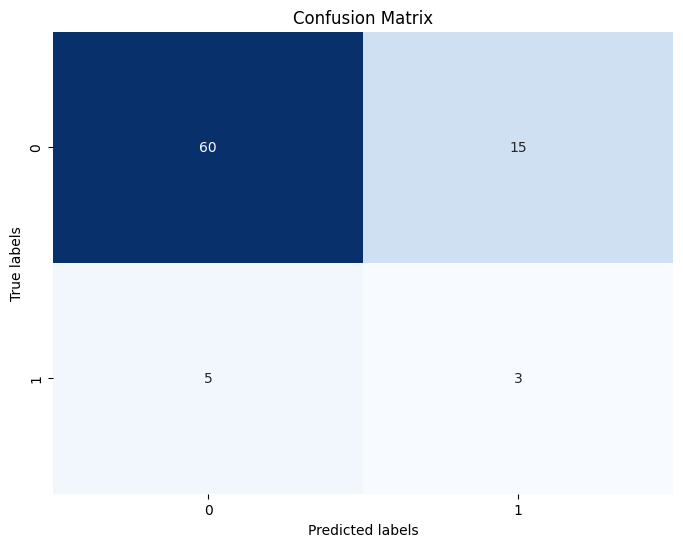

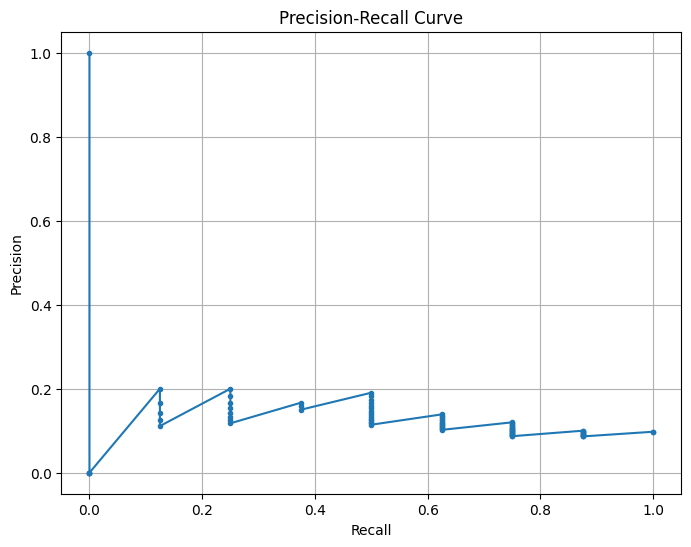

Validation Accuracy: 0.7590361445783133


In [337]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_curve, accuracy_score
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split

# Compute confusion matrix
cm = confusion_matrix(y_val, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_val, clf.decision_function(X_val))

# Compute accuracy
accuracy = accuracy_score(y_val, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()

print("Validation Accuracy:", accuracy)


In [339]:

clf = SVC(C=10)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("Training Accuracy:", accuracy)

Training Accuracy: 0.8541666666666666


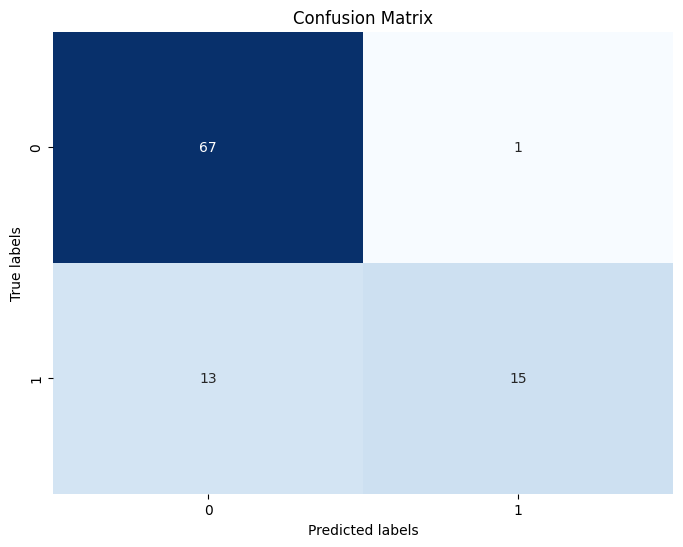

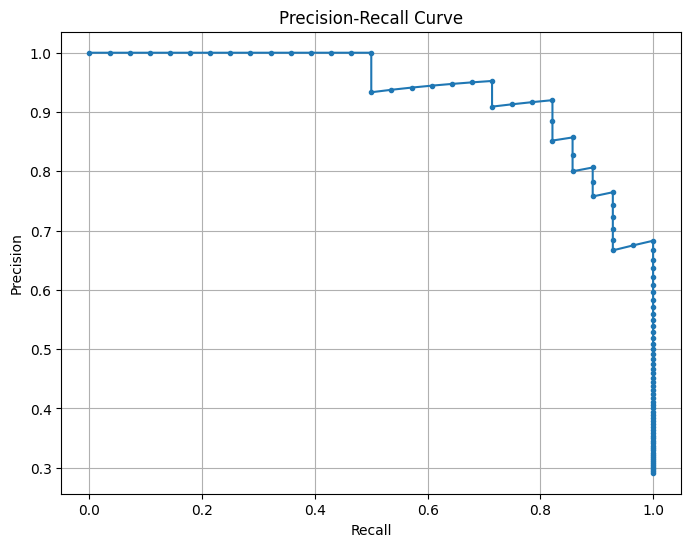

In [340]:

cm = confusion_matrix(y_train, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_train, clf.decision_function(X_train))

# Compute accuracy
accuracy = accuracy_score(y_train, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


try with random forest
==

In [341]:
rf = RandomForestClassifier(max_depth = 50, n_estimators = 1000)
rf.fit(X_train, y_train)
y_pred = clf.predict(X_val)
accuracy = accuracy_score(y_val, y_pred)
print("validation Accuracy:", accuracy)

validation Accuracy: 0.7590361445783133


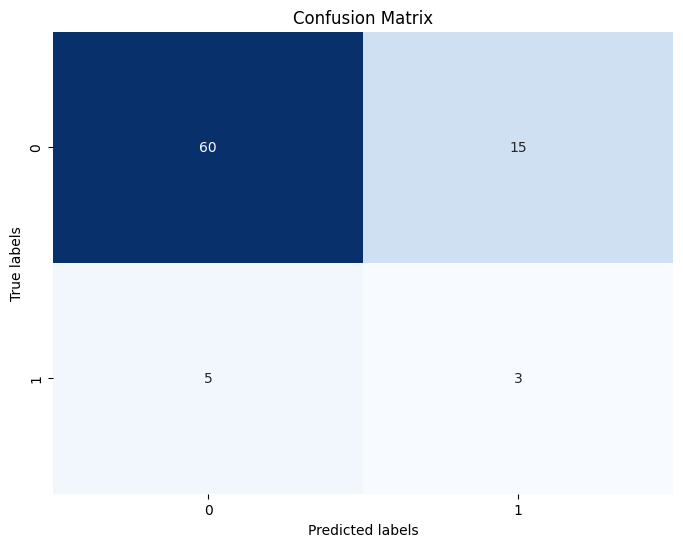

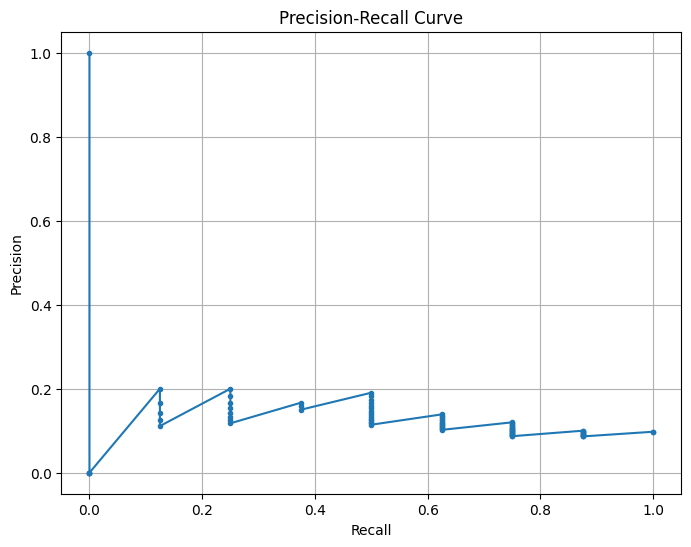

In [330]:

cm = confusion_matrix(y_val, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_val, clf.decision_function(X_val))

# Compute accuracy
accuracy = accuracy_score(y_val, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()


training Accuracy: 0.8541666666666666


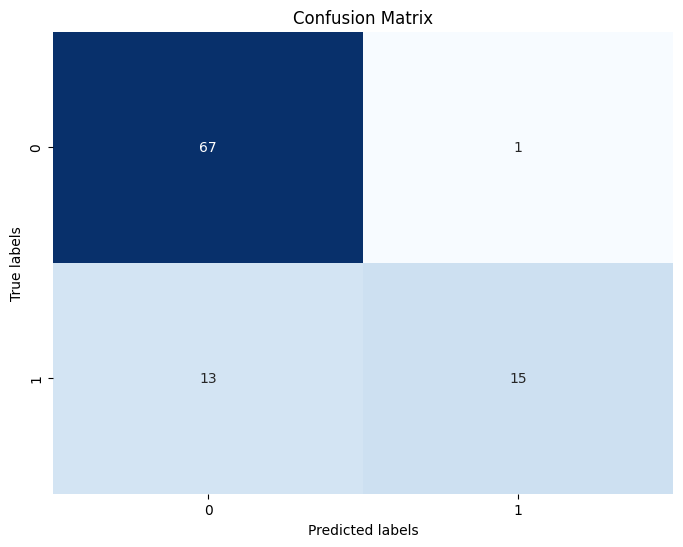

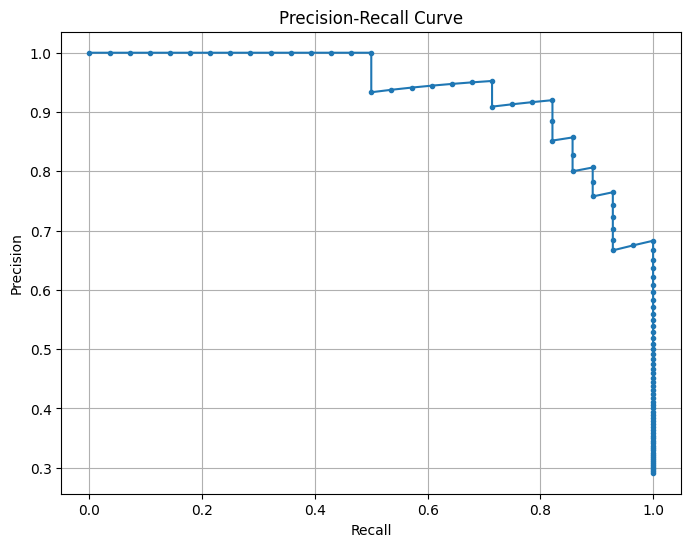

In [331]:
y_pred = clf.predict(X_train)
accuracy = accuracy_score(y_train, y_pred)
print("training Accuracy:", accuracy)

cm = confusion_matrix(y_train, y_pred)

# Visualize confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, cmap='Blues', fmt='g', cbar=False)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.title('Confusion Matrix')
plt.show()

# Compute precision and recall
precision, recall, thresholds = precision_recall_curve(y_train, clf.decision_function(X_train))

# Compute accuracy
accuracy = accuracy_score(y_train, y_pred)

# Plot precision-recall curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.grid(True)
plt.show()